In [1]:
import os
import chromadb
import base64
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from IPython.display import Image, display, Markdown
from datasets import load_dataset
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [2]:
dataset = load_dataset("detection-datasets/fashionpedia")

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

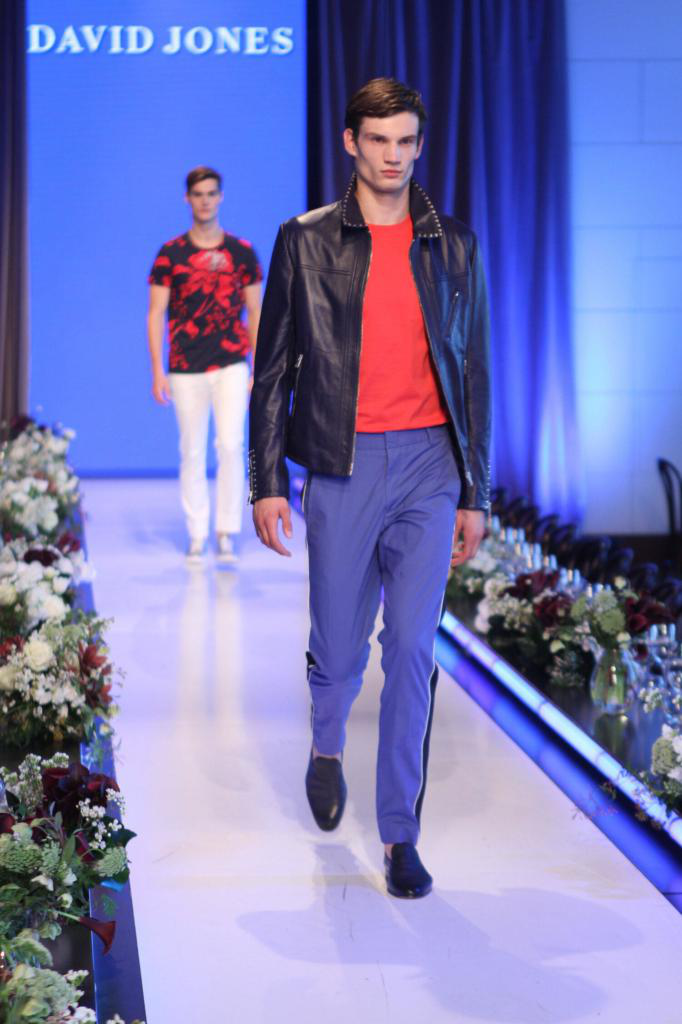

In [3]:
dataset['train'][3]['image']

In [6]:
# Define the folder to save the images
dataset_folder = "G:\\fashion_dataset"
os.makedirs(dataset_folder, exist_ok=True)

# Function to save images
def save_images(dataset, dataset_folder, num_images=100):
    for i in range(num_images):
        # Get the image data
        image = dataset['train'][i]['image']
        
        # Save the image
        image.save(os.path.join(dataset_folder, f'image_{i+1}.png'))

# Save the first 1000 images
save_images(dataset, dataset_folder, num_images=100)

print(f"Saved the first 100 images to {dataset_folder}")

Saved the first 1000 images to G:\fashion_dataset


In [7]:
# Instantiate the ChromaDB CLient
chroma_client = chromadb.PersistentClient(path="G:\\image_rag\\image_vdb")
# Instantiate the ChromaDB Image Loader
image_loader = ImageLoader()
# Instantiate CLIP embeddings
CLIP = OpenCLIPEmbeddingFunction()

# Create the image vector database
image_vdb = chroma_client.get_or_create_collection(name="image", embedding_function = CLIP, data_loader = image_loader)

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

G:\Anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mural\.cache\huggingface\hub\models--laion--CLIP-ViT-B-32-laion2B-s34B-b79K. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [8]:
# Initialize lists for ids and uris (uniform resource identifiers, which in this case is just the path to the image)
ids = []
uris = []

# Iterate over each file in the dataset folder
for i, filename in enumerate(sorted(os.listdir(dataset_folder))):
    if filename.endswith('.png'):
        file_path = os.path.join(dataset_folder, filename)
        
        # Append id and uri to respective lists
        ids.append(str(i))
        uris.append(file_path)

# Assuming multimodal_db is already defined and available
image_vdb.add(
    ids=ids,
    uris=uris
)

print("Images added to the database.")

Images added to the database.


In [9]:
# Validate the VectorDB with .count()
image_vdb.count()

100

ID: 12
Distance: 1.4672646522521973
Path: G:\fashion_dataset\image_2.png


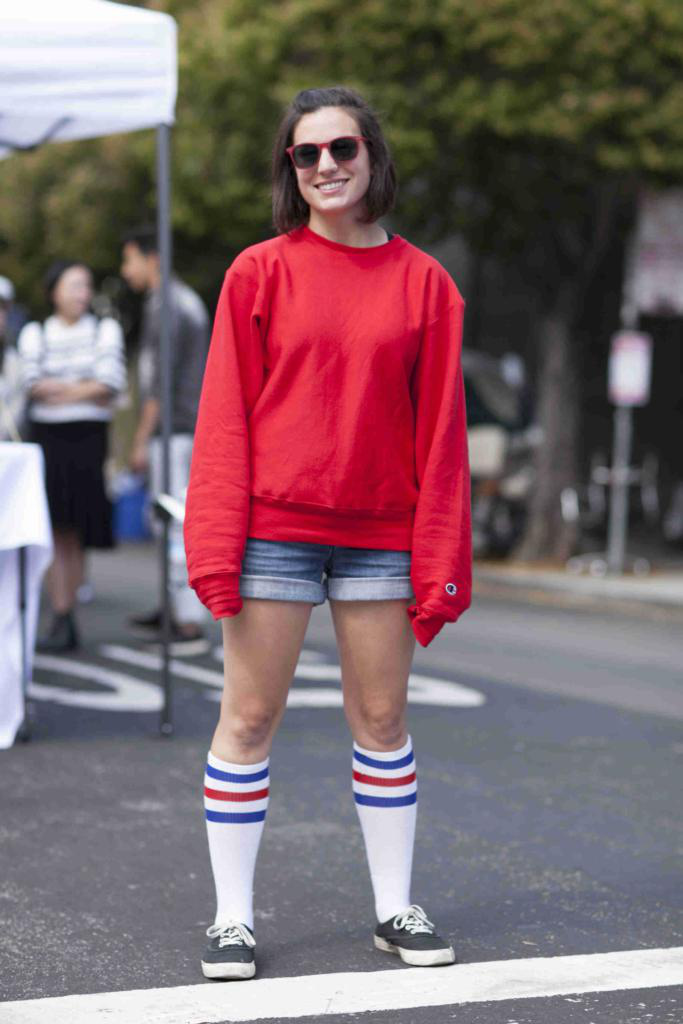



ID: 62
Distance: 1.5194296836853027
Path: G:\fashion_dataset\image_65.png


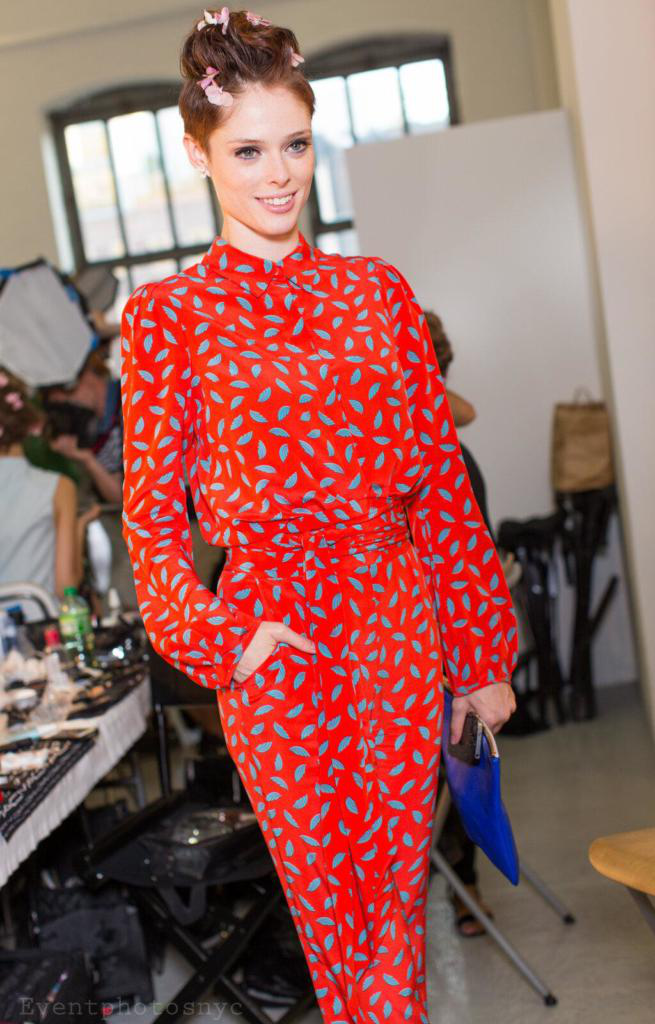



ID: 4
Distance: 1.5270302295684814
Path: G:\fashion_dataset\image_12.png


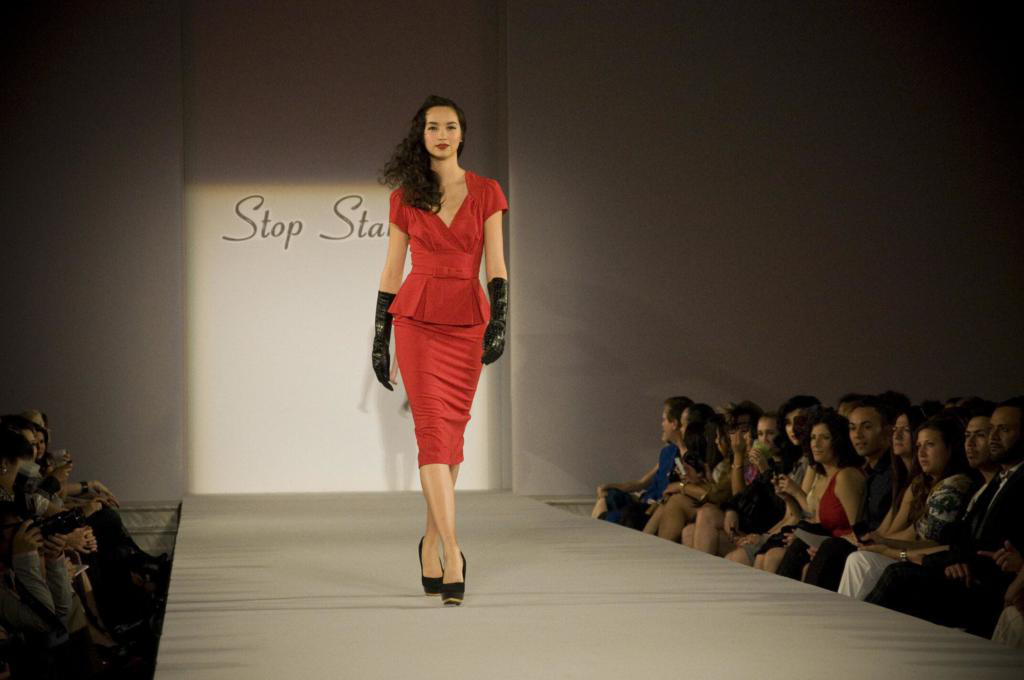



ID: 86
Distance: 1.5642802715301514
Path: G:\fashion_dataset\image_87.png


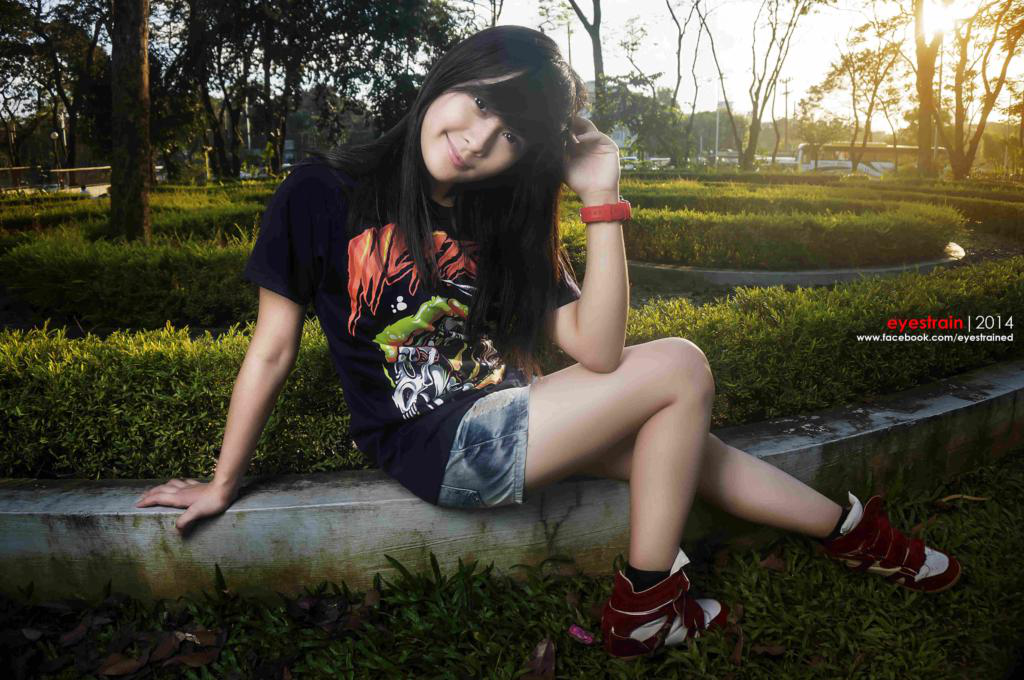



ID: 23
Distance: 1.5765283107757568
Path: G:\fashion_dataset\image_3.png


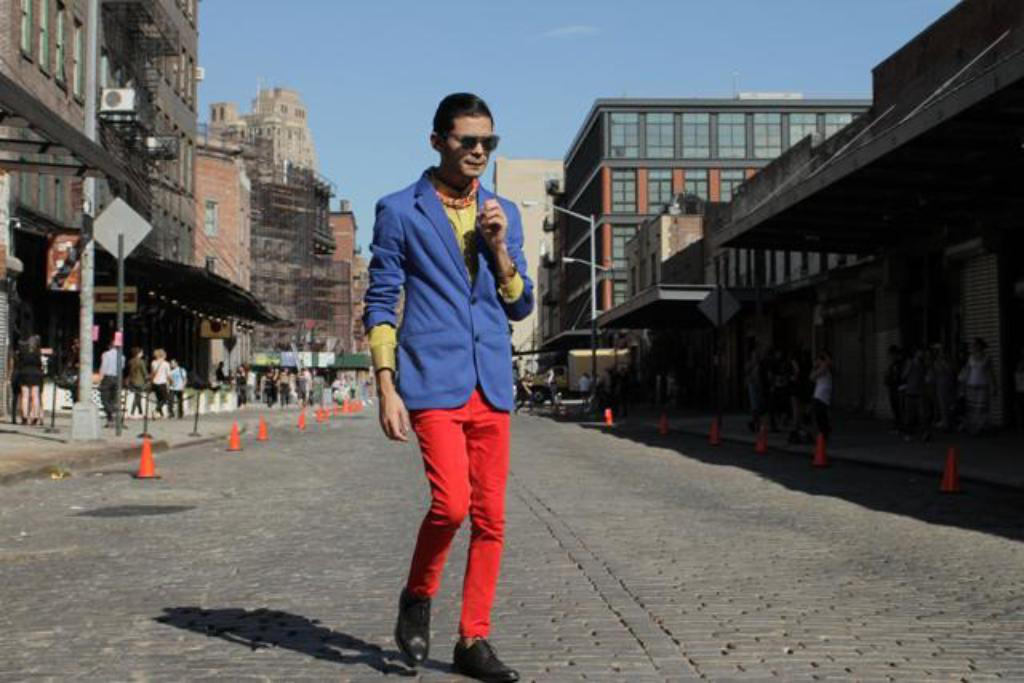

In [10]:
def query_db(query, results=5):
    results = image_vdb.query(
        query_texts=[query],
        n_results=results,
        include=['uris', 'distances'])
    return results

def print_results(results):
    for idx, uri in enumerate(results['uris'][0]):
        print(f"ID: {results['ids'][0][idx]}")
        print(f"Distance: {results['distances'][0][idx]}")
        print(f"Path: {uri}")
        display(Image(filename=uri, width=300))
        print("\n")

# Testing it out
query = 'red tops'
results = query_db(query)
print_results(results)

In [22]:
# groq_api_key = os.getenv("GROQ-API_KEY")
from langchain_community.chat_models import ChatOllama
from langchain.llms import Ollama
llm = Ollama(model="llava:7b")
parser = StrOutputParser()
# Define the Prompt 
image_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful fashion and styling assistant. Answer the user's question  using the given image context with direct references to parts of the images provided."
                    " Maintain a more conversational tone, don't make too many lists. Use markdown formatting for highlights, emphasis, and structure."),
        (
            "user",
            [
                {"type": "text", "text": "What are some ideas for styling {user_query}"},
                {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_data_1}"},
                {"type": "image_url", "image_url": "data:image/jpeg;base64,{image_data_2}"},
            ],
        ),
    ]
)

# Define the LangChain Chain
vision_chain = image_prompt | llm | parser

In [23]:
vision_chain 

ChatPromptTemplate(input_variables=['image_data_1', 'image_data_2', 'user_query'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template="You are a helpful fashion and styling assistant. Answer the user's question  using the given image context with direct references to parts of the images provided. Maintain a more conversational tone, don't make too many lists. Use markdown formatting for highlights, emphasis, and structure.")), HumanMessagePromptTemplate(prompt=[PromptTemplate(input_variables=['user_query'], template='What are some ideas for styling {user_query}'), ImagePromptTemplate(input_variables=['image_data_1'], template={'url': 'data:image/jpeg;base64,{image_data_1}'}), ImagePromptTemplate(input_variables=['image_data_2'], template={'url': 'data:image/jpeg;base64,{image_data_2}'})])])
| Ollama(model='llava:7b')
| StrOutputParser()

In [24]:
def format_prompt_inputs(data, user_query):
    inputs = {}

    # Add user query to the dictionary
    inputs['user_query'] = user_query

    # Get the first two image paths from the 'uris' list
    image_path_1 = data['uris'][0][0]
    image_path_2 = data['uris'][0][1]
    
    # Encode the first image
    with open(image_path_1, 'rb') as image_file:
        image_data_1 = image_file.read()
    inputs['image_data_1'] = base64.b64encode(image_data_1).decode('utf-8')
    
    # Encode the second image
    with open(image_path_2, 'rb') as image_file:
        image_data_2 = image_file.read()
    inputs['image_data_2'] = base64.b64encode(image_data_2).decode('utf-8')
    
    return inputs

In [28]:
display(Markdown("## FashionRAG is At Your Service!"))
display(Markdown("What would you like to style today?"))

query = input("\n")

# Running Retrieval and Generation
results = query_db(query, results=2)
prompt_input = format_prompt_inputs(results, query)
response = vision_chain.invoke(prompt_input)

display(Markdown("---"))
# Showing Retrieved Pictures
display(Markdown("**Example Picture 1:**"))
display(Image(filename=results['uris'][0][0], width=300))
display(Markdown("**Example Picture 2:**"))
display(Image(filename=results['uris'][0][1], width=300))
display(Markdown("---"))
# Printing LLM Response
display(Markdown(response))

## FashionRAG is At Your Service!

What would you like to style today?


 red tops


KeyboardInterrupt: 